In [20]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/RotationCurveFit.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

In [21]:
data_info = gen_dataInfo_from_tfCube()

redshift : 0.6
half_light_radius : 0.5
vcirc : 200.0
sini : 1.0
slitWidth : 0.02


returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)
total tfCube time: 4.799376010894775 (sec)
total getSlitSpectra time: 1.339095115661621 (sec)


In [22]:
RotFit = RotationCurveFit(data_info, active_par_key = ['r_0','r_t','v_0','v_a','redshift'])

time cost in gaussFit_spec2D: 0.1837460994720459 (secs)


In [23]:
params_rot = RotFit.optFit_rotation_curve(RotFit.gaussfit_peakLambda)
params_rot

{'r_t': 0.49777116894298434,
 'r_0': -0.0079990398684516,
 'v_a': 199.96976141926692,
 'v_0': -1.7384839129835206,
 'redshift': 0.6000093434035411,
 'sini': 0.9999999998981126}

In [25]:
chain_info = RotFit.run_MCMC(Nwalker=100, Nsteps=5000)

100%|██████████| 5000/5000 [00:15<00:00, 320.35it/s]

Total MCMC time (mins): 0.2603525678316752


In [26]:
Chain0 = ChainTool(chain_info, Nburn=0, Nend=100000)
Chain1 = ChainTool(chain_info, Nburn=100000, Nend=200000)
Chain2 = ChainTool(chain_info, Nburn=200000, Nend=300000)
Chain3 = ChainTool(chain_info, Nburn=300000, Nend=400000)
Chain4 = ChainTool(chain_info, Nburn=400000, Nend=500000)

# Plot

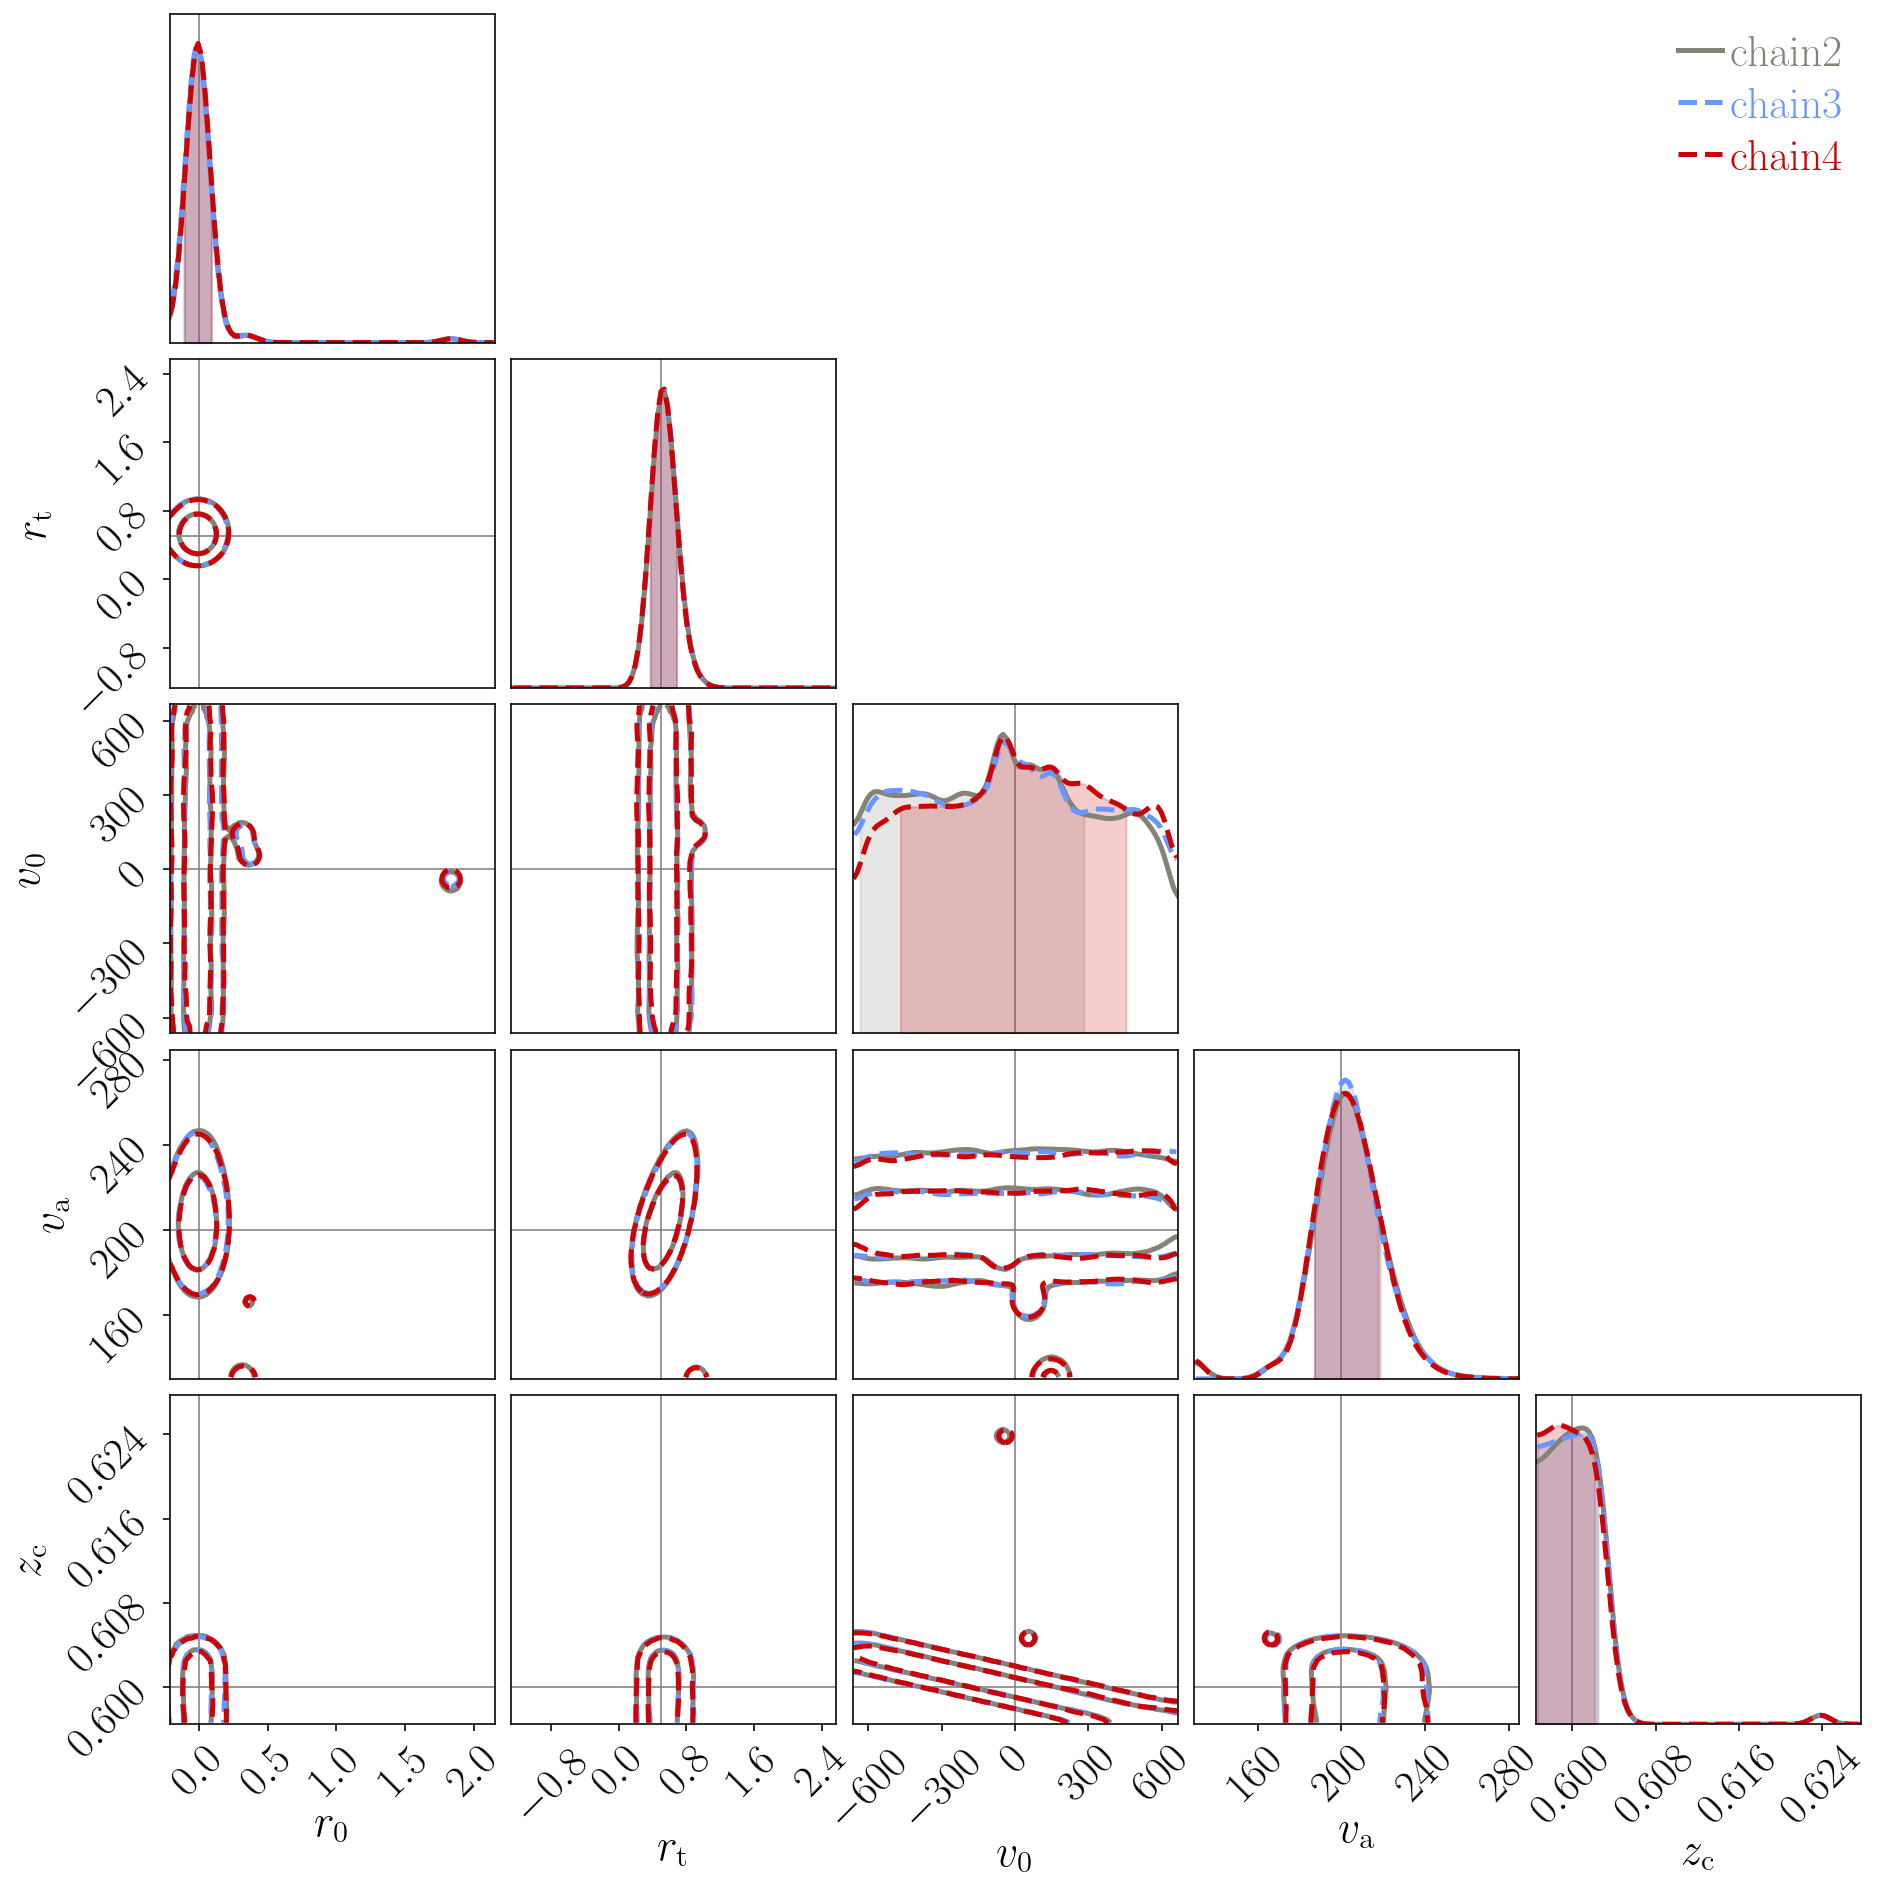

In [27]:
Nchains = 3
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['r_0','r_t','v_0','v_a','redshift']

parID1,parName1,par_x1 = Chain1.select_par_info(select_par_key)

c = ChainConsumer()
#c.add_chain(Chain0.chain[:, parID1]       , parameters=parName1 ,name="$\mathrm{chain0}$")
#c.add_chain(Chain1.chain[:, parID1]       , parameters=parName1 ,name="$\mathrm{chain1}$")
c.add_chain(Chain2.chain[:, parID1]       , parameters=parName1 ,name="$\mathrm{chain2}$")
c.add_chain(Chain3.chain[:, parID1]       , parameters=parName1 ,name="$\mathrm{chain3}$")
c.add_chain(Chain4.chain[:, parID1]       , parameters=parName1 ,name="$\mathrm{chain4}$")



c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=22,tick_font_size=22
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=False
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(6. + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

In [11]:
a=np.arange(10)

In [20]:
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [21]:
b=np.atleast_2d(a)
b

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [22]:
a.shape

(10,)

In [23]:
b.shape

(1, 10)

In [24]:
b[0].shape

(10,)

In [25]:
x=b>5
a[x[0]]

array([6, 7, 8, 9])

### vectorization

In [8]:
def get_likeli(active_par):    # in order to run emcee
#     print(active_par.shape)
    Tstart=time.time()
    l=RotFit.cal_loglike(active_par)
    Time_MCMC=(time.time()-Tstart)
#     print ("get_likeli time (secs):",Time_MCMC)
    return l

In [15]:
np.atleast_2d([1,1,1,1]).shape

(1, 4)

In [21]:
get_likeli(np.atleast_2d([1,1,1,1,1]))

array([-1.99090794e+08])

In [10]:
Nwalker=50; Nsteps=8000; Ncpu=4
Ndim = RotFit.Ntot_active_par
sampler = emcee.EnsembleSampler(Nwalker, Ndim, get_likeli, vectorize=True, a=2.0)
                # emcee a parameter: Npar < 4 -> better set a > 3  ( a = 5.0 )
                #                  : Npar > 7 -> better set a < 2  ( a = 1.5 )

starting_point = [ RotFit.Parameter.par_fid[item] for item in RotFit.active_par_key ]
std = [ RotFit.Parameter.par_std[item] for item in RotFit.active_par_key ]

p0_walkers = emcee.utils.sample_ball(starting_point, std, size=Nwalker)
posInfo = sampler.run_mcmc(p0_walkers,5)
p0_walkers = posInfo.coords
sampler.reset()

Tstart=time.time()

posInfo = sampler.run_mcmc(p0_walkers, Nsteps)

Time_MCMC=(time.time()-Tstart)/60.
print ("Total MCMC time (mins):",Time_MCMC)


Total MCMC time (mins): 0.12026766538619996
